In [43]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import fbeta_score, make_scorer

In [44]:
df = pd.read_csv('bank-additional-full.csv', sep = ';', na_values = ['unknown', 999])
df = df.drop(columns = ['duration']) # drop future information
df['ncalls'] = df['campaign'] - 1
df = df.drop(columns = ['campaign', 'emp.var.rate', 'euribor3m'])
df.shape

(41188, 18)

In [45]:
# deal with pdays
def categorize_pdays(days):
    if np.isnan(days):
        return 'never contacted'
    elif days == 0:
        return 'contacted immediately'
    elif days <= 7:
        return 'contacted within a week'
    elif days <= 14:
        return 'contacted between 8 to 14 days'
    elif days <= 21:
        return 'contacted between 15 to 21 days'
    elif days <= 28:
        return 'contacted between 22 to 28 days'
    else:
        return 'contacted after 28 days'

df['pdays'] = df['pdays'].apply(categorize_pdays)

In [46]:
X = df.drop(columns = 'y')
y = df['y']
y = y.replace({'yes': 1, 'no': 0})
print(X.shape)
print(y.shape)

(41188, 17)
(41188,)


In [47]:
cat_ftrs = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

ordinal_ftrs = ['education', 'month', 'day_of_week', 'pdays']
ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                 'professional.course', 'university.degree'],
                ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                ['mon', 'tue', 'wed', 'thu', 'fri'], 
                ['contacted immediately', 'contacted within a week', 'contacted between 8 to 14 days',
                 'contacted between 15 to 21 days', 'contacted between 22 to 28 days', 'never contacted']]

num_ftrs = ['age', 'previous', 'ncalls', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']

In [48]:
# one-hot encoder
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')),
    ('scaler', StandardScaler())])

# ordinal encoder
ordinal_transformer = Pipeline(steps = [
    ('imputer2', SimpleImputer(strategy = 'constant', fill_value = 'NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
    ('scaler', StandardScaler())])

# standard scaler
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [49]:
def MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3):
    test_scores = []
    best_models = []
    fbeta_scorer = make_scorer(fbeta_score, beta = 1)
    for i, random_state in enumerate(random_states):
        X_other, X_test, y_other, y_test = train_test_split(X, y, random_state = 42 * random_state, test_size = 0.2, 
                                                            stratify = y)
        # imbalanced data set
        kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42 * random_state)
        if 'random_state' in ML_algo.get_params().keys():
            ML_algo.set_params(random_state = 42 * random_state)
        else:
            ML_algo = ML_algo

        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid = param_grid,
                            scoring = fbeta_scorer, cv = kf,
                            return_train_score = True, n_jobs = -1, verbose = True)
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)
        #print('Best model parameter(s):', grid.best_params_)
        #print('Validation score:', grid.best_score_)
        best_models.append(grid) # save the model
        #y_test_pred_prob = best_models[-1].predict_proba(X_test)[:, 1]
        y_test_pred = best_models[-1].predict(X_test)

        # confusion matrix
        #cm = confusion_matrix(y_test, y_test_pred)
        #disp = ConfusionMatrixDisplay(cm, display_labels = ['Class 0', 'Class 1'])
        #fig, ax = plt.subplots(figsize = (5, 3))
        #disp.plot(ax = ax)
        #plt.tight_layout()
        #plt.show()
        
        test_fbeta = fbeta_score(y_test, y_test_pred, beta = 1)
        test_scores.append(test_fbeta)
        #print('Test average precision:', test_scores[i])
    return test_scores, best_models

In [50]:
from sklearn.ensemble import RandomForestClassifier

random_states = [42, 0, 456]
ML_algo = RandomForestClassifier()
param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
    'randomforestclassifier__max_features': [0.15, 0.5, 0.75, 1],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample', 
                                             {0: 1, 1: 5}, {0: 1, 1: 10}]
}

test_scores_rf, best_models_rf = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

print('Mean:', np.mean(test_scores_rf))
print('Standard deviation:', np.std(test_scores_rf))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mean: 0.5046434070387497
Standard deviation: 0.004389040252001994


In [51]:
# random_state = 42
model = best_models_rf[0].best_estimator_
df_X = pd.DataFrame(data = preprocessor.fit_transform(X), columns = preprocessor.get_feature_names_out())

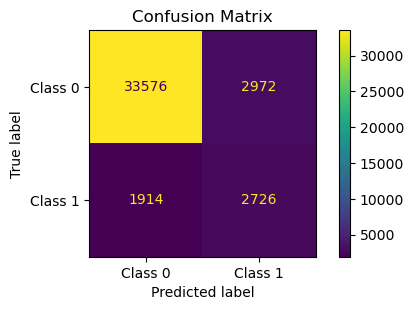

In [52]:
# confusion matrix
cm = confusion_matrix(y, model.predict(X))
disp = ConfusionMatrixDisplay(cm, display_labels = ['Class 0', 'Class 1'])
fig, ax = plt.subplots(figsize = (5, 3))
disp.plot(ax = ax)
plt.tight_layout()
plt.title('Confusion Matrix')
plt.savefig('/Users/ihiro/Desktop/confusion_matrix.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [53]:
y_pred = model.predict(X)
result_df = pd.DataFrame({
    'Predicted Label': y_pred,
    'True Label': y
})
result_df.head()

,Predicted Label,True Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [54]:
# save predictions
result_df.to_csv('/Users/ihiro/Desktop/bank_makreting_predictions.csv', index = False) 

In [55]:
# save model
import pickle

filename  = '/Users/ihiro/Desktop/bank_makreting_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)